In [1]:
import torch
from model.encoder_sketchy import Encoder
from model.self_interaction import SelfInteraction
from model.cross_interaction import CrossInteraction
from PIL import Image,ImageDraw
import PIL
from matplotlib import pyplot as plt
from torchvision import transforms
import numpy as np
plt.rcParams['figure.figsize'] = (15.0, 15.0)

In [2]:
def resize_mask(mask):
    mask=mask.reshape([16,16,3]).numpy()
    mask=mask.astype(np.uint8)
    mask=Image.fromarray(mask).resize((256,256))
    return mask

def merge_mask(img,mask):
    img=img.resize((256,256),Image.ANTIALIAS)
    mask_img=np.array(img)*np.array(mask)
    mask_img=Image.fromarray(mask_img)
    return mask_img

def draw_border(img):
    img=img.resize((256,256))
    draw=ImageDraw.Draw(img)
    draw.line((0,255,255,255),fill='black')
    draw.line((0,0,0,255),fill='black')
    draw.line((255,0,255,255),fill='black')
    draw.line((0,0,255,0),fill='black')
    return img

In [3]:
ckpt_path='/home/xjq/code/shoe/DLI-Net/ckpt/dli-sketchy.pth'
img_encoder=Encoder('mid').cuda()
sk_encoder=Encoder('mid').cuda()
ckpt=torch.load(ckpt_path)
img_encoder.load_state_dict(ckpt['encoder_img'])
sk_encoder.load_state_dict(ckpt['encoder_sk'])
self_interaction=SelfInteraction(0.5)
match=CrossInteraction('2norm')

In [77]:
img_path='/home/xjq/code/dataset/sketchy/photo/tx_000100000000/train/airplane/n02691156_542.jpg'
sk_path='/home/xjq/code/dataset/sketchy/sketch/tx_000100000000/train/airplane/n02691156_542-4.png'
norm=transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
input_transform=transforms.Compose([transforms.Resize(256),transforms.ToTensor(), norm])
img=Image.open(img_path)
img_tensor=input_transform(img)
img_tensor=img_tensor.unsqueeze(0).cuda()
sk=Image.open(sk_path)
sk_tensor = input_transform(sk)
sk_tensor=sk_tensor.unsqueeze(0).cuda()

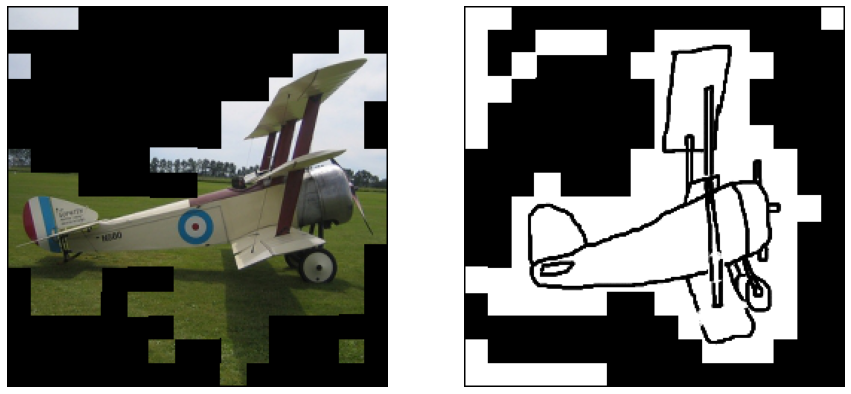

In [78]:
img_fea=img_encoder(img_tensor)[0]
img_fea,img_keep_index=self_interaction.visualize(img_fea)
sk_fea=sk_encoder(sk_tensor)[0]
sk_fea,sk_keep_index=self_interaction.visualize(sk_fea)
img_keep_index=img_keep_index[0].cpu().unsqueeze(1).expand(128,3)
sk_keep_index=sk_keep_index[0].cpu().unsqueeze(1).expand(128,3)
# [128,3]
sk_mask=torch.zeros([256,3])
img_mask=torch.zeros([256,3])
sk_mask.scatter_(0,sk_keep_index,1)
img_mask.scatter_(0,img_keep_index,1)

img_mask=resize_mask(img_mask)
vis_img=merge_mask(img,img_mask)
vis_img=draw_border(vis_img)
sk_mask=resize_mask(sk_mask)
vis_sk=merge_mask(sk,sk_mask)
vis_sk=draw_border(vis_sk)
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].imshow(vis_img)
ax[0].set_axis_off()
ax[1].imshow(vis_sk)
ax[1].set_axis_off()
plt.savefig('./self_interaction.svg',format='svg')
plt.show()